In [1]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os

In [2]:
import PF
import ROI
importlib.reload(PF)
importlib.reload(ROI)

<module 'ROI' from 'C:\\Users\\krq\\Documents\\GitHub\\radwatch-analysis\\ROI.py'>

In [3]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx
        
def plot_peak_region(spectrum,source_energies):
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    print(target_peaks)
    for i,j,isotope in zip(source_energies,target_peaks,source_isotopes):
        spec = spectrum
        counts = spec.counts_vals
        energies = spec.energies_kev
        idx = f_near(energies,i) 
        roi_low = idx - 50
        roi_high = idx + 50

        plot_counts = counts[roi_low:roi_high]
        plot_energies = energies[roi_low:roi_high]

        roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(j)
        rlow = roi_low_bins[0][0]
        rhi = roi_high_bins[0][-1]
        plot_counts = counts[rlow:rhi]
        plot_energies = energies[rlow:rhi]

        rlow = roi_low_bins[0][0]
        rhi = roi_low_bins[0][-1]
        low_counts = counts[rlow:rhi]
        low_energies = energies[rlow:rhi]

        rlow = roi_high_bins[0][0]
        rhi = roi_high_bins[0][-1]
        high_counts = counts[rlow:rhi]
        high_energies = energies[rlow:rhi]

        rlow = roi_peak_bins[0][0]
        rhi = roi_peak_bins[0][-1]
        peak_counts = counts[rlow:rhi]
        peak_energies = energies[rlow:rhi]

        fig,ax = plt.subplots()
        ax.plot(plot_energies,plot_counts)
        ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
        ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
        ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
        ax.set_yscale('log')
        plt.title(isotope)
        
def efficiency(roi_result,source_activities,branching_ratio,roi_uncer):
    eff = []
    eff_uncer = []
    for i,j,k,l in zip (roi_result,source_activities,branching_ratio,roi_uncer):
        eff.append(i/spectrum.livetime/j/k)
        eff_uncer.append(l/spectrum.livetime/j/k)
    return eff, eff_uncer

In [4]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))

    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
        


In [5]:
spec = r'C:\rad data\Radwatch data\efficiency_calibration_2020-3-5.Spe'
bg = r'C:\rad data\Radwatch data\Background_Spectrum_12_20_19.Spe'
spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)

SpeFile: Reading file C:\rad data\Radwatch data\efficiency_calibration_2020-3-5.Spe


C:\anaconda3\lib\site-packages\becquerel\parsers\spectrum_file.py:136: SpectrumFileParsingWarning: Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.
  SpectrumFileParsingWarning)


SpeFile: Reading file C:\rad data\Radwatch data\Background_Spectrum_12_20_19.Spe


In [6]:
# apply the kernel to the data to get SNR
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

C:\anaconda3\lib\site-packages\becquerel\core\peakfinder.py:181: DeprecationWarning: channels is deprecated and will be removed in a future release. Use centroids instead.
  'release. Use centroids instead.', DeprecationWarning)


[506.5, 793.5, 914.5, 1345.5, 2111.5, 3881.5, 3950.5, 7107.5]


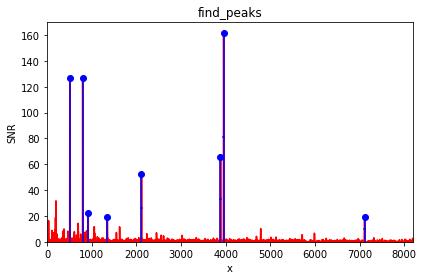

In [7]:
cal.peakfinder.find_peaks(min_snr=15, xmin=400)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 0.369757 keV/channel
fit gain: 0.369756699383546 keV/channel
fit channels: [ 914.5 3881.5 3950.5 7107.5]


C:\anaconda3\lib\site-packages\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)


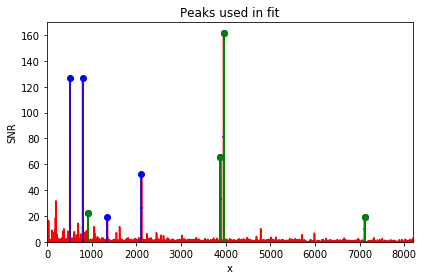

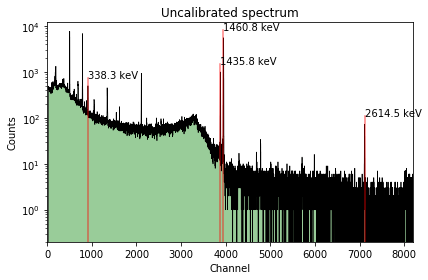

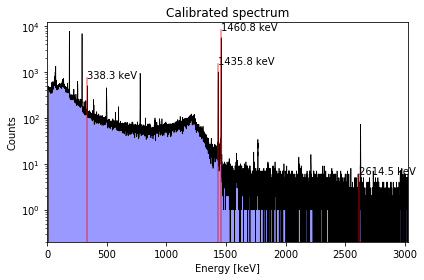

In [8]:
# perform calibration
cal.fit(
    [1435.795, 1460.82,2614.51],
    optional=[201.83,306.78, 351.93, 338.32,569.33,604.721,788.742,795.864, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.3, 10],
    de_max=100.,
)
plot_calibrator(cal)
spectrum = cal.peakfinder.spectrum


[246.5, 539.5, 706.5, 1564.5, 1792.5, 1874.5, 2827.5, 4560.5, 5518.5]


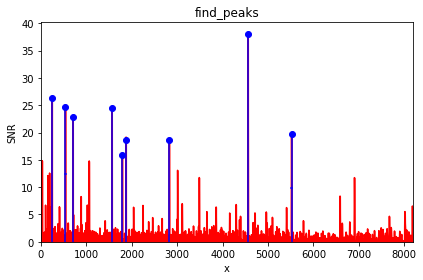

In [9]:
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(bg, kernel)
cal = bq.AutoCalibrator(finder)
cal.peakfinder.find_peaks(min_snr=15, xmin=200)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 0.320388 keV/channel
fit gain: 0.3203875656420919 keV/channel
fit channels: [2827.5 4560.5 5518.5]


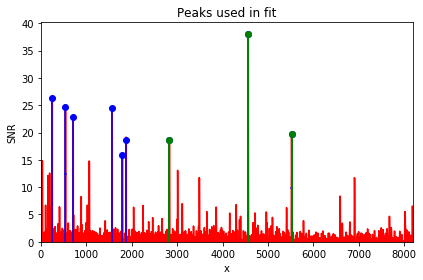

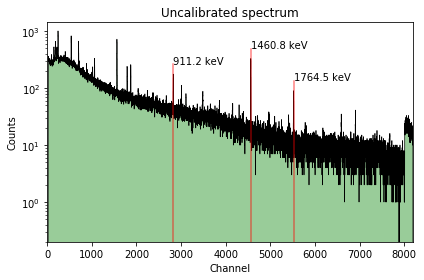

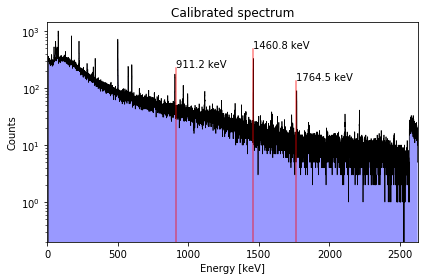

In [10]:
# perform calibration
cal.fit(
    [1460.82, 1764.49],
    optional=[186.21,238.63,609.32,911.20,242.00,295.22,338.32,351.93,1620.50],
    gain_range=[2.5e-2, 10],
    de_max=100.,
)
plot_calibrator(cal)
background = cal.peakfinder.spectrum

In [11]:
#Find Lu-176, La-138, K-40
source_isotopes = np.array(['Lu_176_1','Lu_176_2',
                            'La_138_1']); #get counts under the peak subtrack the background
source_energies1 = np.array([186,294,
                           782]);
source_activities1 = np.array([454.09,454.09,
                             454.09]);#Bq/L
branching_ratio1 = np.array([0.86,0.94,
                           0.34]);


In [12]:
roi = ROI.ROI(spectrum, background, source_energies1, sub_type = 0)
roi.find_peak_energies()
target_peaks1 = roi.target_peaks
roi_result1,roi_uncer1 = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks1)
print('ROI result:',roi_result1)
print('uncertainties:',roi_uncer1)
#print('Lu_176 PF result:',pf_result)

[188 294 781]
ROI result: [30526.242457432225, 30194.953869594916, 4815.360297297406]
uncertainties: [195.92537487243555, 186.00262733447576, 78.84976000835583]


[188 294 781]


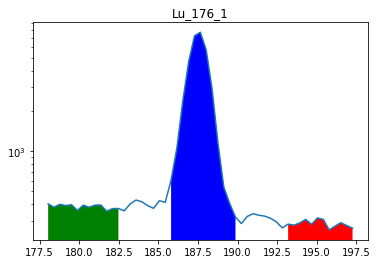

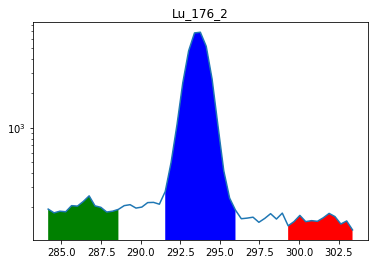

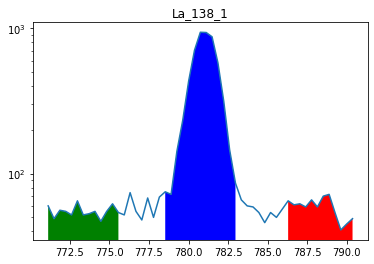

In [13]:
plot_peak_region(spectrum,source_energies1)

In [14]:
source_isotopes = np.array(['La_138_2',
                           'K-40']);
source_energies2 = np.array([1435.795,
                           1460]);
source_activities2 = np.array([454.09,
                             454.09]);#Bq/L
branching_ratio2 = np.array([0.66,
                           0.11]);
roi = ROI.ROI(spectrum, background, source_energies2, sub_type = 0)
delta_e = 7
window = np.array([[-2, -1], [-0.5, 0.5], [1, 2]])
roi.set_sideband(delta_e,window)
target_peaks2 = roi.target_peaks
roi_result2,roi_uncer2 = roi.get_counts()
print(target_peaks2)
print('ROI result:',roi_result2)
print('uncertainties:',roi_uncer2)

[1435.795 1460.   ]
ROI result: [6068.345212161873, 34313.8729777027]
uncertainties: [81.86291692352387, 186.70675374478836]


[1436. 1461.]


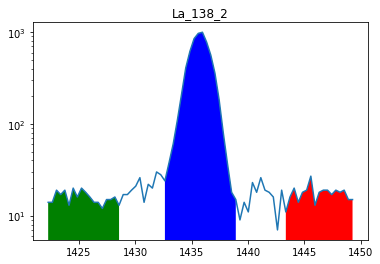

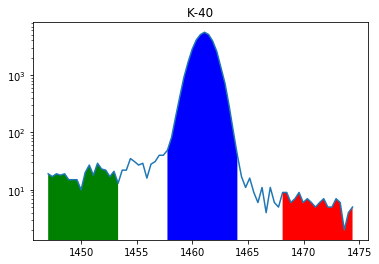

In [15]:
plot_peak_region(spectrum,source_energies2)

In [16]:
roi_result = roi_result1 + roi_result2
roi_uncer = roi_uncer1 + roi_uncer2
target_peaks = np.append(target_peaks1, target_peaks2)
source_activities = np.append(source_activities1,source_activities2)
branching_ratio = np.append(branching_ratio1,branching_ratio2)
source_energies = np.append(source_energies1,source_energies2)
print(roi_result,roi_uncer,target_peaks, source_activities, branching_ratio)


[30526.242457432225, 30194.953869594916, 4815.360297297406, 6068.345212161873, 34313.8729777027] [195.92537487243555, 186.00262733447576, 78.84976000835583, 81.86291692352387, 186.70675374478836] [ 188.  294.  781. 1436. 1461.] [454.09 454.09 454.09 454.09 454.09] [0.86 0.94 0.34 0.66 0.11]


In [17]:
eff,eff_uncer = efficiency(roi_result,source_activities,branching_ratio,roi_uncer)
print(eff,eff_uncer)

[0.0010856765657216777, 0.0009824989218557045, 0.000433187021289707, 0.00028122369411195724, 0.009541191656735242] [6.968154971115654e-06, 6.052249048224908e-06, 7.093278707846259e-06, 3.793751196269211e-06, 5.191500598732941e-05]


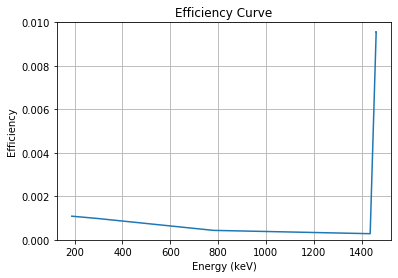

In [18]:

plt.title('Efficiency Curve')
plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.errorbar(source_energies, eff, yerr=eff_uncer, fmt='')
plt.grid()
plt.ylim(0, 0.01)
plt.show()
